# Anime Info Scraper

In this script I will be scraping all the info from https://myanimelist.net/anime/genre/27/Shounen?page=1
- All text info will be stored in anime_info.csv file
- All the images will be stored in images folder


## Imports

In [43]:
import requests
from bs4 import BeautifulSoup as bs
import re
import csv
import json
import os
import pandas as pd
from PIL import Image
import threading

### Anime parser class

This class contains all the code to parse anime info from the raw HTML

In [32]:
class Anime:
    def __init__(self, block):
        self.block = block
        self.info = self.get_info()

    def get_name(self):
        name = self.block.select_one('.h2_anime_title').text
        return name
    
    def get_type(self):
        info = self.block.select('.info span')
        anime_type = info[0].get_text().split(',')[0]
        return anime_type
    
    def get_year(self):
        info = self.block.select('.info span')
        year = info[0].get_text().split(',')[1]
        return year
    
    def get_episodes(self):
        info = self.block.select('.info span')
        episodes =  info[3].get_text().split()[0]
        
        try:
            episodes = int(episodes)
        except:
            pass
        
        return episodes
    
    def get_runtime(self):
        info = self.block.select('.info span')
        runtime = int(info[4].get_text().split()[0])
        return runtime
    
    def get_genres(self):
        genres = [g.text for g in self.block.select('.genre a')]
        return genres
    
    
    def get_synopsis(self): 
        remove_items = ['\r', '\n']
        synopsis_text = self.block.select_one('.synopsis p').text

        for i in remove_items:
            synopsis_text = synopsis_text.replace(i, '')

        synopsis = synopsis_text
        
        return synopsis
    
    def get_rating(self):
        rating = self.block.select_one('.js-score').text
        return rating
    
    def get_members(self):
        members = self.block.select_one('.js-members').text 
        return members
    
    
    def get_properties(self):
        
        properties = self.block.select('.property')
        d = {}
        for p in properties:
            caption = p.select_one('.caption').text
            value = [item.text for item in p.select('.item')]

            if caption == 'Themes':
                caption = 'Theme'

            if caption == 'Studios':
                caption = 'Studio'
            
            if caption == 'Demographics':
                caption = 'Demographic'

            if len(value) == 1:
                value = value[0]

            d[caption] = value
            
        return d
    
    def get_info(self):
        info = {}
        info['Name'] = self.get_name()
        info['Type'] = self.get_type()
        info['Year'] = self.get_year()
        info['Episodes'] = self.get_episodes()
        info['Genres'] = self.get_genres()
        info['Synopsis'] = self.get_synopsis()
        info['Rating'] = self.get_rating()
        info['Members'] = self.get_members()
        
        properties = self.get_properties()
        info = {**info, **properties}
        
        return info
    
        
    def get_image(self):
        unformated_name = self.get_name()
        formated_name = re.findall(r'[\w\s\d]+', unformated_name)
        formated_name = ''.join(formated_name)
        
        image_link = self.block.select_one('.image img')['data-src']
        
        while True:
            try:
                image_file = requests.get(image_link, timeout=10).content
                break
            except:
                pass

        return (formated_name,image_file)

### Save Images class
This class contains code to save images from a page

In [33]:
class Save_images:
    def __init__(self, blocks, path):
        self.blocks = blocks
        self.path = path
        
    def save_images(self):
        threads = []
        
        for b in self.blocks:
            t = threading.Thread(target=self.save_image, args=[b])
            t.start()
            
        for t in threads:
            t.join()
            
            
    def save_image(self,block):
        anime = Anime(block)
        name, image = anime.get_image()
        with open(self.path+'/'+name+'.jpg', mode='wb') as f:
            f.write(image)

### Constant Values

In [35]:
CSV_FILE_NAME = 'anime_info.csv'
IMAGES_FOLDER_NAME = 'images'
URL = 'https://myanimelist.net/anime/genre/27/Shounen?page={}'

## Scraping code

In [37]:
# create anime_info.csv file
f = open(CSV_FILE_NAME, mode='w', newline='', encoding='utf-8')

# create images folder
os.mkdir(IMAGES_FOLDER_NAME)

# this list contains name of all columns of anime_info file
keys = ['Name', 'Type', 'Year', 'Episodes', 'Genres', 'Synopsis', 'Rating', 'Members', 'Studio', 'Source', 'Theme', 'Demographic']

# create csv writer object and write column names
writer = csv.DictWriter(f, keys)
writer.writeheader()

# page_number to keep track of pages
page_number = 1

# keep scraping until there is no more anime info
while True:
    
    # create link
    page_link = URL.format(page_number)
    
    # send request and create soup
    print(f'Scraping page no: {page_number}', end=' ')
    req = requests.get(page_link, timeout=10)
    soup = bs(req.text)
    blocks = soup.select('.js-anime-category-producer')
    
    # condition to end scraping
    if len(blocks) == 0:
        print('No more info to scrap, Exiting...')
        f.close()
        break
        
    # parse the content and write to the csv file
    for b in blocks:
        anime = Anime(b)
        writer.writerow(anime.info)
        
    
    print('Info ✔', end=' ')
    
    # save all images of a page
    images = Save_images(blocks=blocks, path=IMAGES_FOLDER_NAME)
    images.save_images()
    print('Images ✔')
        
    # increment page number
    page_number += 1



Scraping page no: 1 Info ✔ Images ✔
Scraping page no: 2 Info ✔ Images ✔
Scraping page no: 3 Info ✔ Images ✔
Scraping page no: 4 Info ✔ Images ✔
Scraping page no: 5 Info ✔ Images ✔
Scraping page no: 6 Info ✔ Images ✔
Scraping page no: 7 Info ✔ Images ✔
Scraping page no: 8 Info ✔ Images ✔
Scraping page no: 9 Info ✔ Images ✔
Scraping page no: 10 Info ✔ Images ✔
Scraping page no: 11 Info ✔ Images ✔
Scraping page no: 12 Info ✔ Images ✔
Scraping page no: 13 Info ✔ Images ✔
Scraping page no: 14 Info ✔ Images ✔
Scraping page no: 15 Info ✔ Images ✔
Scraping page no: 16 Info ✔ Images ✔
Scraping page no: 17 Info ✔ Images ✔
Scraping page no: 18 Info ✔ Images ✔
Scraping page no: 19 Info ✔ Images ✔
Scraping page no: 20 Info ✔ Images ✔
Scraping page no: 21 Info ✔ Images ✔
Scraping page no: 22 No more info to scrap, Exiting...


## See the data

In [40]:
data = pd.read_csv('anime_info.csv')

In [41]:
data.head()

,Name,Type,Year,Episodes,Genres,Synopsis,Rating,Members,Studio,Source,Theme,Demographic
0,Shingeki no Kyojin,TV,2013,25,"['Action', 'Drama']","Centuries ago, mankind was slaughtered to near...",8.53,3506730,Wit Studio,Manga,"['Gore', 'Military', 'Survival']",Shounen
1,Death Note,TV,2006,37,"['Supernatural', 'Suspense']","Brutal murders, petty thefts, and senseless vi...",8.62,3487701,Madhouse,Manga,Psychological,Shounen
2,Fullmetal Alchemist: Brotherhood,TV,2009,64,"['Action', 'Adventure', 'Drama', 'Fantasy']",After a horrific alchemy experiment goes wrong...,9.13,2963310,Bones,Manga,Military,Shounen
3,Boku no Hero Academia,TV,2016,13,['Action'],"The appearance of ""quirks,"" newly discovered s...",7.92,2695251,Bones,Manga,"['School', 'Super Power']",Shounen
4,Naruto,TV,2002,220,"['Action', 'Adventure', 'Fantasy']","Moments prior to Naruto Uzumaki's birth, a hug...",7.97,2544058,Pierrot,Manga,Martial Arts,Shounen


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2088 entries, 0 to 2087
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         2088 non-null   object 
 1   Type         2088 non-null   object 
 2   Year         2088 non-null   object 
 3   Episodes     2088 non-null   object 
 4   Genres       2088 non-null   object 
 5   Synopsis     2088 non-null   object 
 6   Rating       2088 non-null   float64
 7   Members      2088 non-null   int64  
 8   Studio       2088 non-null   object 
 9   Source       1808 non-null   object 
 10  Theme        1441 non-null   object 
 11  Demographic  2088 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 195.9+ KB


## See Images

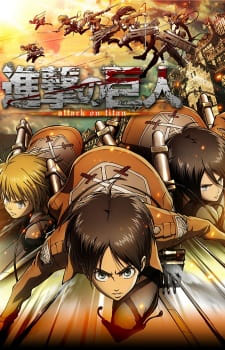

In [44]:
Image.open('images/' + os.listdir('images')[0])

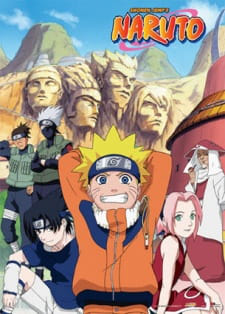

In [50]:
Image.open('images/' + os.listdir('images')[1])

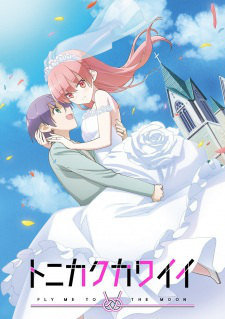

In [55]:
Image.open('images/' + os.listdir('images')[100])